<a href="https://colab.research.google.com/github/harshit-046/ai-project/blob/main/Forcasting_bitcoin_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Data Acquisition**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
DATA_SOURCE = "yfinance"
TICKER = "BTC-USD"
START_DATE = "2016-03-01"
END_DATE = "2021-02-27" # (Paper says 26-02, but yfinance end dates are exclusive, so we add one day)
TRAIN_SPLIT_PERCENT = 0.8  # 80% for training
TIME_STEP = 1

In [ ]:
print(f"Downloading data for {TICKER} from {START_DATE} to {END_DATE}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

/tmp/ipython-input-3859939632.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

In [ ]:
print("\n--- Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

# Check for NULL values, as mentioned in the paper [cite: 139]
print(f"\nNull values found: {df.isnull().sum().sum()}")


--- Data Head ---
Price            Close        High         Low        Open     Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD    BTC-USD
Date                                                                 
2016-03-01  435.122986  439.653015  432.319000  437.916992   74895800
2016-03-02  423.989014  435.916992  423.989014  435.131012   74955296
2016-03-03  421.651001  425.372986  419.411011  423.911987  100484000
2016-03-04  410.938995  425.178009  410.938995  421.835999   90856096
2016-03-05  400.570007  411.256989  394.035004  410.781006  135384992

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2016-03-01 to 2021-02-26
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1824 non-null   float64
 1   (High, BTC-USD)    1824 non-null   float64
 2   (Low, BTC-USD)     1824 non-null   float64
 3   (Open, BTC-USD)    1824 non-null 

**Data Preprocessing**

In [ ]:
# The paper mentions removing rows with NULL values [cite: 139]
df.dropna(inplace=True)

In [ ]:
# Let's check the exact column names in your DataFrame
print("--- Available Columns in df ---")
print(df.columns)
print("\n")

# We will use df[['Close']] which is the standard way to select a
# column and keep it as a DataFrame.
# If your column name is different (e.g., 'close'), change it here.
try:
    data = df[['Close']]
except KeyError:
    print("ERROR: The column 'Close' was not found in your DataFrame.")
    print("Please check the 'Available Columns' printed above and correct the column name.")
    # Stop execution if the column isn't found
    raise

dataset = data.values  # Convert to numpy array

# This shape should now be (1824, 1) or similar, not (1824, 0)
print(f"Shape of dataset before scaling: {dataset.shape}")

if dataset.shape[1] == 0:
    print("ERROR: The dataset is still empty. Please check your 'df' DataFrame.")
else:
    # The paper uses MinMaxScaler to scale data between 0 and 1 [cite: 141]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    print("--- Data Scaled Successfully ---")

    # The paper used 80% for training and 20% for testing [cite: 145]
    training_data_len = int(np.ceil(len(dataset) * TRAIN_SPLIT_PERCENT))
    train_data = scaled_data[0:int(training_data_len), :]
    test_data = scaled_data[training_data_len - TIME_STEP:, :] # [cite: 145]

    print(f"Training data length: {len(train_data)}")
    print(f"Test data length: {len(test_data)}")

--- Available Columns in df ---
MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


Shape of dataset before scaling: (1824, 1)
--- Data Scaled Successfully ---
Training data length: 1460
Test data length: 365


In [ ]:
# This function converts an array of values into a dataset of
# sequences (X) and their corresponding next value (y)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create training and testing sequences
x_train, y_train = create_dataset(train_data, TIME_STEP)
x_test, y_test = create_dataset(test_data, TIME_STEP)

In [ ]:
# The LSTM model expects 3 dimensions: [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"\nTraining data shape (X, y): {x_train.shape}, {y_train.shape}")
print(f"Testing data shape (X, y): {x_test.shape}, {y_test.shape}")


Training data shape (X, y): (1459, 1, 1), (1459,)
Testing data shape (X, y): (364, 1, 1), (364,)


**Model Building and Training**

In [ ]:
# This function creates the correct model architecture based on the loop
def build_model(model_name, neurons, time_step):
    model = Sequential()

    # Get the input shape from our training data
    input_shape = (time_step, 1)

    if model_name == 'LSTM':
        # Paper's proposed model [cite: 74, 153]
        model.add(LSTM(neurons, activation='tanh', input_shape=input_shape))

    elif model_name == 'Bi-LSTM':
        # Bi-Directional LSTM [cite: 182]
        model.add(Bidirectional(
            LSTM(neurons, activation='tanh'),
            input_shape=input_shape
        ))

    elif model_name == 'GRU':
        # Gated Recurrent Unit [cite: 188]
        model.add(GRU(neurons, activation='tanh', input_shape=input_shape))

    # All models have the same output layer [cite: 149, 299]
    model.add(Dense(1, activation='linear'))

    # Compile the model as specified in the paper [cite: 151, 302]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae')

    return model

In [ ]:
model_types = ['LSTM', 'Bi-LSTM', 'GRU']
neuron_counts = [25, 50, 75, 100, 125, 150]
results_list = [] # To store our data for the table

In [ ]:
print("--- Starting Full Experiment Replication (18 models) ---")
print("This will take a significant amount of time.")

for model_name in model_types:
    for neurons in neuron_counts:

        print(f"\n--- Training: {model_name} with {neurons} neurons ---")

        # Build the model
        model = build_model(model_name, neurons, TIME_STEP)

        # Train the model [cite: 152]
        model.fit(
            x_train,
            y_train,
            batch_size=72,
            epochs=50,
            validation_data=(x_test, y_test),
            verbose=1  # Set to 1 to see progress for every epoch
        )

        # Make predictions
        predictions_scaled = model.predict(x_test)

        # De-normalize
        predictions = scaler.inverse_transform(predictions_scaled)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate all four metrics
        mae = mean_absolute_error(y_test_actual, predictions)
        mse = mean_squared_error(y_test_actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_actual, predictions)

        print(f"Results for {model_name}-{neurons}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2:   {r2:.4f}")

        # Store results
        results_list.append({
            "Model": model_name,
            "Neurons": neurons,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2
        })

print("\n--- Full Experiment Complete ---")

--- Starting Full Experiment Replication (18 models) ---
This will take a significant amount of time.

--- Training: LSTM with 25 neurons ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0782 - val_loss: 0.2138
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0572 - val_loss: 0.1726
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0525 - val_loss: 0.1568
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0496 - val_loss: 0.1485
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0460 - val_loss: 0.1376
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0435 - val_loss: 0.1257
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0386 - val_loss: 0.1074
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0339 - val_loss: 0.0914
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - val_loss: 0.0640
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - val_loss: 0.0431
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0135
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.017

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0734 - val_loss: 0.1953
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0535 - val_loss: 0.1510
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0497 - val_loss: 0.1409
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0449 - val_loss: 0.1295
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0405 - val_loss: 0.1131
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0341 - val_loss: 0.0857
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - val_loss: 0.0580
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - val_loss: 0.0228
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - val_loss: 0.0173
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0121
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0121
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0706 - val_loss: 0.1767
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0508 - val_loss: 0.1375
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0462 - val_loss: 0.1312
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413 - val_loss: 0.1089
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - val_loss: 0.0875
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - val_loss: 0.0508
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0114
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0165
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0113
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0126
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0127
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0121

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0762 - val_loss: 0.1860
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0554 - val_loss: 0.1477
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0497 - val_loss: 0.1373
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426 - val_loss: 0.1149
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - val_loss: 0.0840
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252 - val_loss: 0.0430
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0117
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0137
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0122
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0110
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0116

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0686 - val_loss: 0.1619
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0501 - val_loss: 0.1328
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0446 - val_loss: 0.1207
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0353 - val_loss: 0.0865
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247 - val_loss: 0.0429
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0105
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0104
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0102
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0100
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0104

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0722 - val_loss: 0.1622
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0505 - val_loss: 0.1350
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0453 - val_loss: 0.1164
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - val_loss: 0.0851
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231 - val_loss: 0.0289
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0164
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0103
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0116
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0107
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0103

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0856 - val_loss: 0.2209
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0598 - val_loss: 0.1724
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0533 - val_loss: 0.1602
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0508 - val_loss: 0.1427
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0458 - val_loss: 0.1310
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0413 - val_loss: 0.1055
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0342 - val_loss: 0.0845
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0268 - val_loss: 0.0550
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - val_loss: 0.0215
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0155
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0129
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0138

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0723 - val_loss: 0.1776
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0526 - val_loss: 0.1378
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0469 - val_loss: 0.1282
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0384 - val_loss: 0.1019
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0305 - val_loss: 0.0659
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - val_loss: 0.0202
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0137
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0102
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0102
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0105
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0108
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0099

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0683 - val_loss: 0.1515
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.1334
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0420 - val_loss: 0.1055
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0312 - val_loss: 0.0674
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0191 - val_loss: 0.0242
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0135
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0098
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0105
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0099

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0707 - val_loss: 0.1473
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0485 - val_loss: 0.1242
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0393 - val_loss: 0.0988
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 - val_loss: 0.0563
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val_loss: 0.0129
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0097
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0104
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0096
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0101
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0094
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0682 - val_loss: 0.1366
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0458 - val_loss: 0.1281
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.0795
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0212 - val_loss: 0.0250
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0109
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0095
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0093
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0097
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0094
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0093

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0712 - val_loss: 0.1389
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0485 - val_loss: 0.1348
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0367 - val_loss: 0.0730
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0216 - val_loss: 0.0204
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0134
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0104
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0096
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0099
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0097
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.00

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0711 - val_loss: 0.1508
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - val_loss: 0.1438
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0460 - val_loss: 0.1329
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395 - val_loss: 0.1058
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0322 - val_loss: 0.0819
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0236 - val_loss: 0.0559
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - val_loss: 0.0196
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0089
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0788 - val_loss: 0.1617
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0588 - val_loss: 0.1699
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0486 - val_loss: 0.1314
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384 - val_loss: 0.1122
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281 - val_loss: 0.0580
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0145
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0090
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0094
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0090

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0686 - val_loss: 0.1429
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - val_loss: 0.1411
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381 - val_loss: 0.0862
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - val_loss: 0.0495
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0094
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0085
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0092
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0087
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0086
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0091

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0676 - val_loss: 0.1429
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0470 - val_loss: 0.1264
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0343 - val_loss: 0.0642
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - val_loss: 0.0217
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0084
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0094
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0085

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0642 - val_loss: 0.1437
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0431 - val_loss: 0.1007
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294 - val_loss: 0.0549
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - val_loss: 0.0151
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0089
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0087
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0097
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0088
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0085
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0088

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0652 - val_loss: 0.1426
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0411 - val_loss: 0.0847
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0246 - val_loss: 0.0266
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0124
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0122
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0093
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0089
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0092
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0086

**Evaluation and Visualization**

In [ ]:
results_df = pd.DataFrame(results_list)

print("\n--- Detailed Comparison Table (Replication of Table I) ---")
print(results_df.to_string()) # .to_string() prints the full table


--- Detailed Comparison Table (Replication of Table I) ---
      Model  Neurons         MAE           MSE         RMSE        R2
0      LSTM       25  476.658811  8.782381e+05   937.143572  0.993448
1      LSTM       50  477.661464  8.835573e+05   939.977279  0.993408
2      LSTM       75  474.773262  8.777877e+05   936.903224  0.993451
3      LSTM      100  485.270167  8.973904e+05   947.306896  0.993305
4      LSTM      125  473.035819  8.718836e+05   933.747087  0.993495
5      LSTM      150  492.928106  8.896187e+05   943.195990  0.993363
6   Bi-LSTM       25  472.435057  8.636750e+05   929.341167  0.993556
7   Bi-LSTM       50  476.172519  8.892723e+05   943.012376  0.993365
8   Bi-LSTM       75  511.594829  9.622854e+05   980.961474  0.992821
9   Bi-LSTM      100  503.088737  9.696556e+05   984.710898  0.992766
10  Bi-LSTM      125  487.609367  9.425151e+05   970.832177  0.992968
11  Bi-LSTM      150  475.310375  8.807014e+05   938.456940  0.993429
12      GRU       25  475.6196

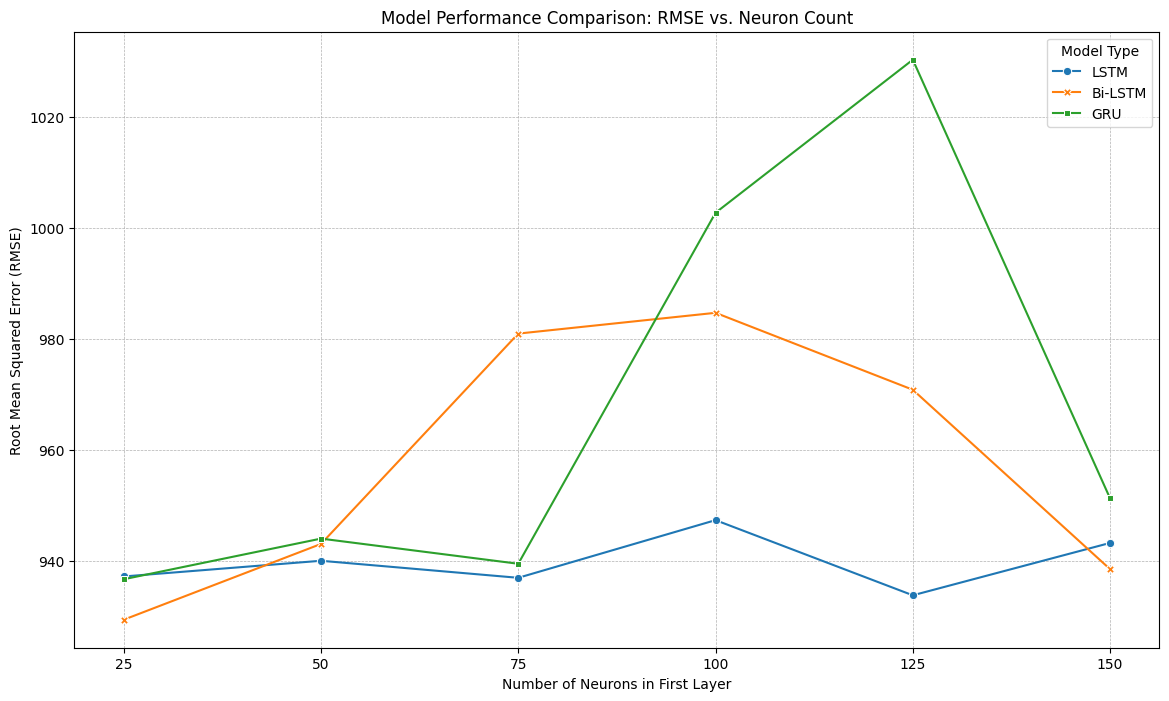

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn makes attractive plots

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=results_df,
    x='Neurons',
    y='RMSE',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False
)
plt.title('Model Performance Comparison: RMSE vs. Neuron Count')
plt.xlabel('Number of Neurons in First Layer')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(neuron_counts) #
plt.legend(title='Model Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

--- Found Best Configurations ---
Best LSTM:   25 neurons (RMSE: 932.6890)
Best Bi-LSTM: 100 neurons (RMSE: 935.0060)
Best GRU:    150 neurons (RMSE: 936.2463)

--- Generating plots for: LSTM with 25 neurons ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


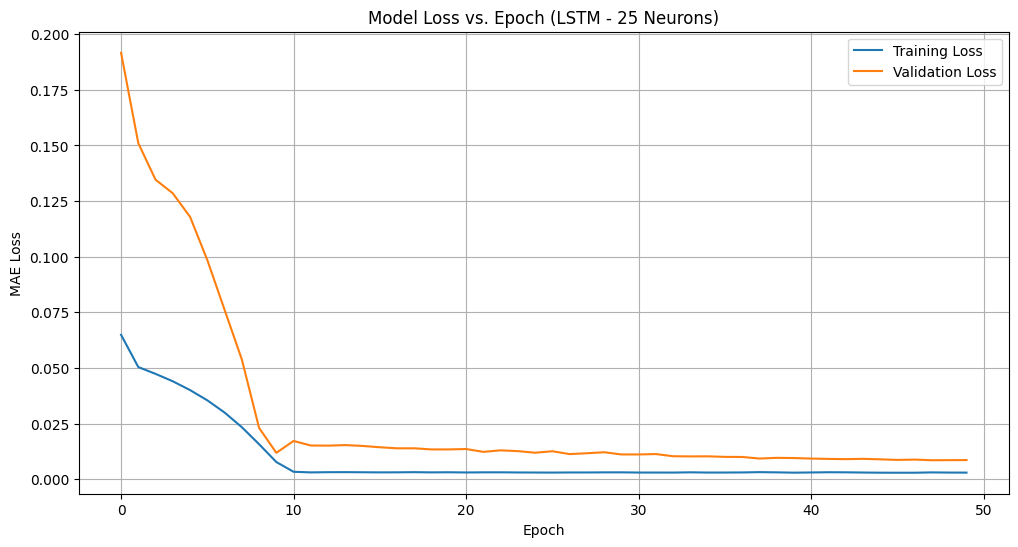

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


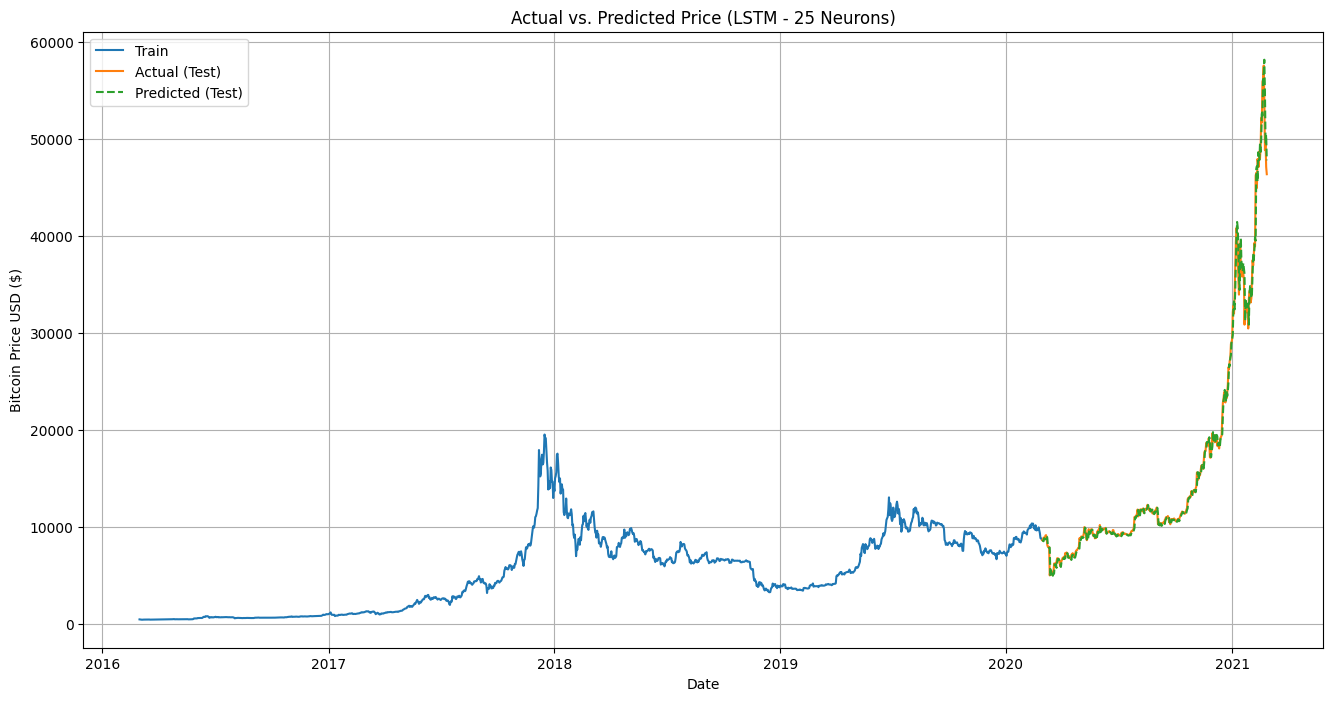

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Generating plots for: Bi-LSTM with 100 neurons ---


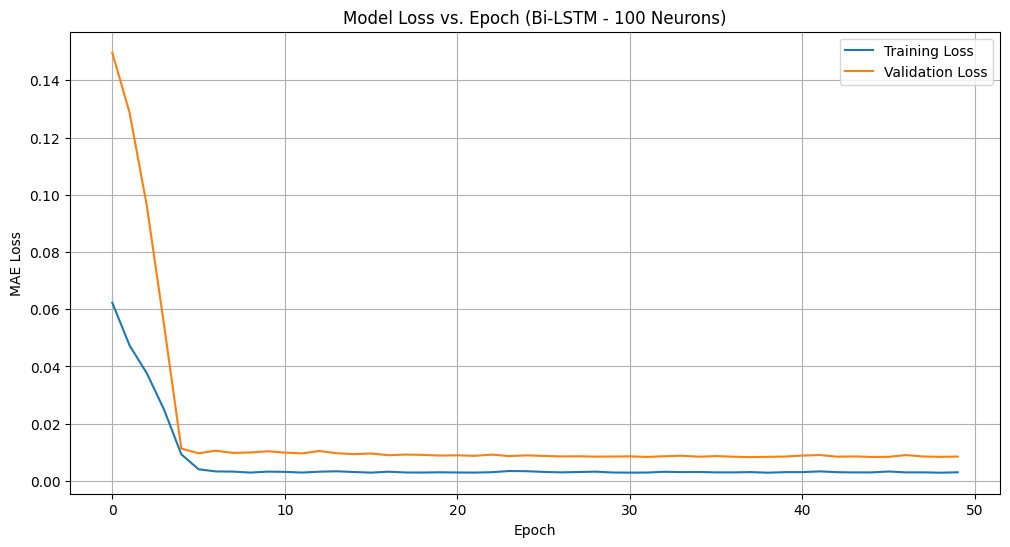

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


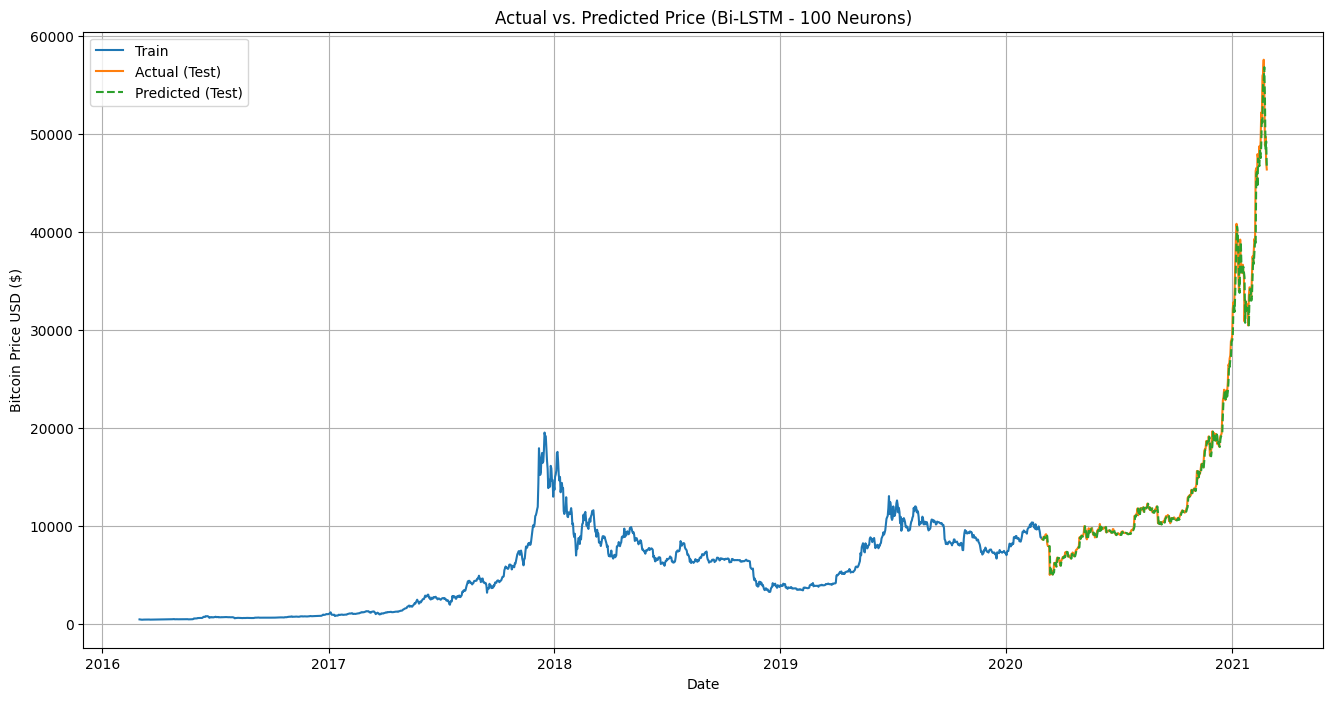

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Generating plots for: GRU with 150 neurons ---


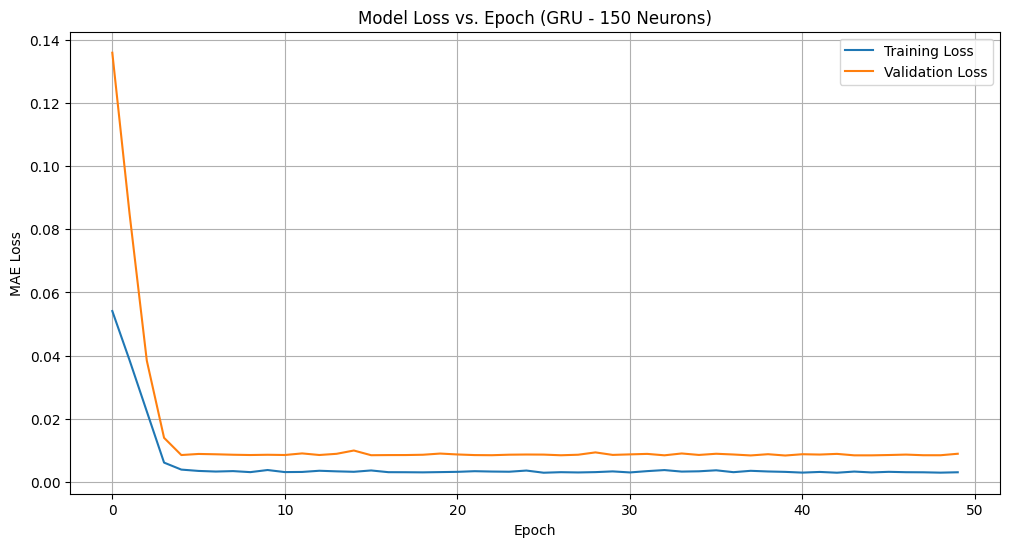

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


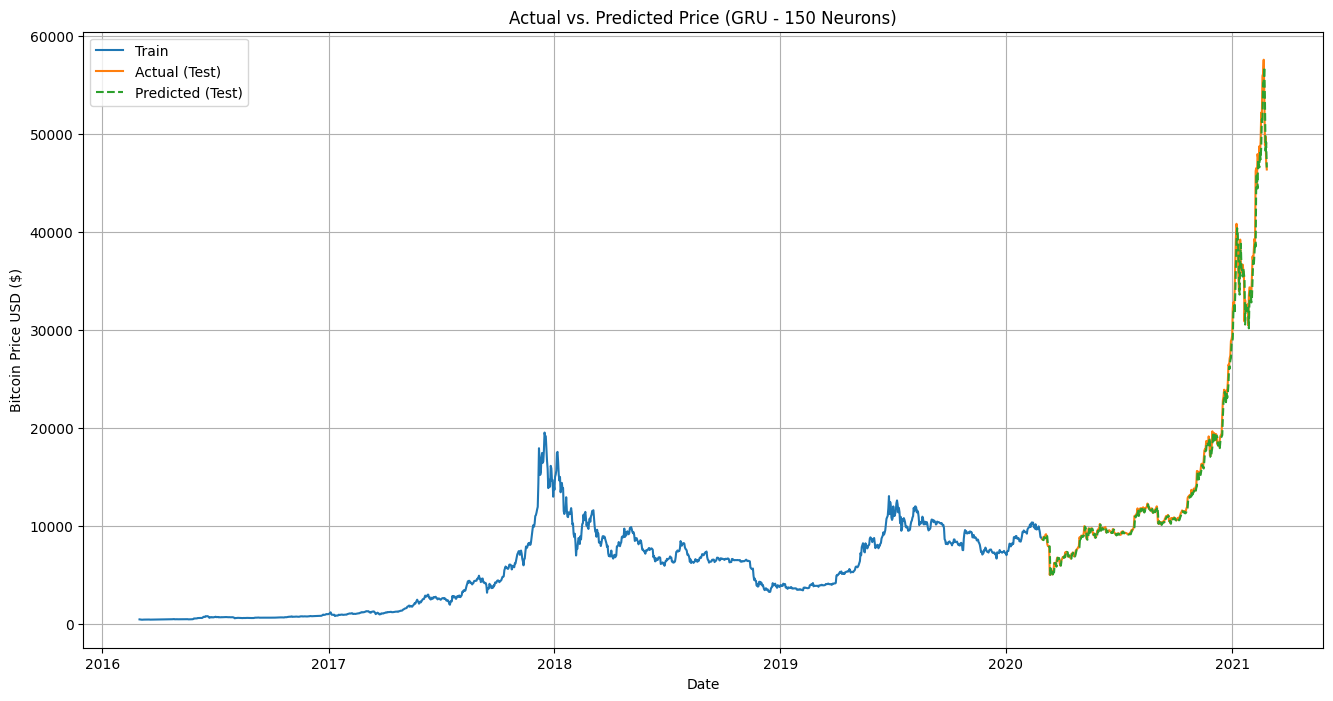

--- Detailed Plot Generation Complete ---


In [ ]:
# We use .loc and .idxmin() to find the row with the lowest RMSE for each model
best_lstm_config = results_df.loc[results_df[results_df['Model'] == 'LSTM']['RMSE'].idxmin()]
best_bilstm_config = results_df.loc[results_df[results_df['Model'] == 'Bi-LSTM']['RMSE'].idxmin()]
best_gru_config = results_df.loc[results_df[results_df['Model'] == 'GRU']['RMSE'].idxmin()]

best_configs = [best_lstm_config, best_bilstm_config, best_gru_config]

print("--- Found Best Configurations ---")
print(f"Best LSTM:   {int(best_lstm_config['Neurons'])} neurons (RMSE: {best_lstm_config['RMSE']:.4f})")
print(f"Best Bi-LSTM: {int(best_bilstm_config['Neurons'])} neurons (RMSE: {best_bilstm_config['RMSE']:.4f})")
print(f"Best GRU:    {int(best_gru_config['Neurons'])} neurons (RMSE: {best_gru_config['RMSE']:.4f})")


for config in best_configs:
    model_name = config['Model']
    neurons = int(config['Neurons'])

    print(f"\n--- Generating plots for: {model_name} with {neurons} neurons ---")

    model = build_model(model_name, neurons, TIME_STEP)

    history = model.fit(
        x_train,
        y_train,
        batch_size=72,
        epochs=50,
        validation_data=(x_test, y_test),
        verbose=0
    )

    # Loss vs. Epoch
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss vs. Epoch ({model_name} - {neurons} Neurons)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Make predictions for the second plot
    predictions_scaled = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    # Prepare data for plotting
    train_plot = data[:training_data_len]
    valid_plot = data[training_data_len:]
    valid_plot['Predictions'] = predictions

    # PLOT 2: Price vs. Days
    plt.figure(figsize=(16, 8))
    plt.title(f'Actual vs. Predicted Price ({model_name} - {neurons} Neurons)')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price USD ($)')
    plt.plot(train_plot['Close'], label='Train')
    plt.plot(valid_plot['Close'], label='Actual (Test)')
    plt.plot(valid_plot['Predictions'], label='Predicted (Test)', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()


print("--- Detailed Plot Generation Complete ---")


--- The best overall model is: LSTM with 25 neurons ---
  Best RMSE: 932.6890
Re-training the best model for final visualization...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/tmp/ipython-input-3521917883.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


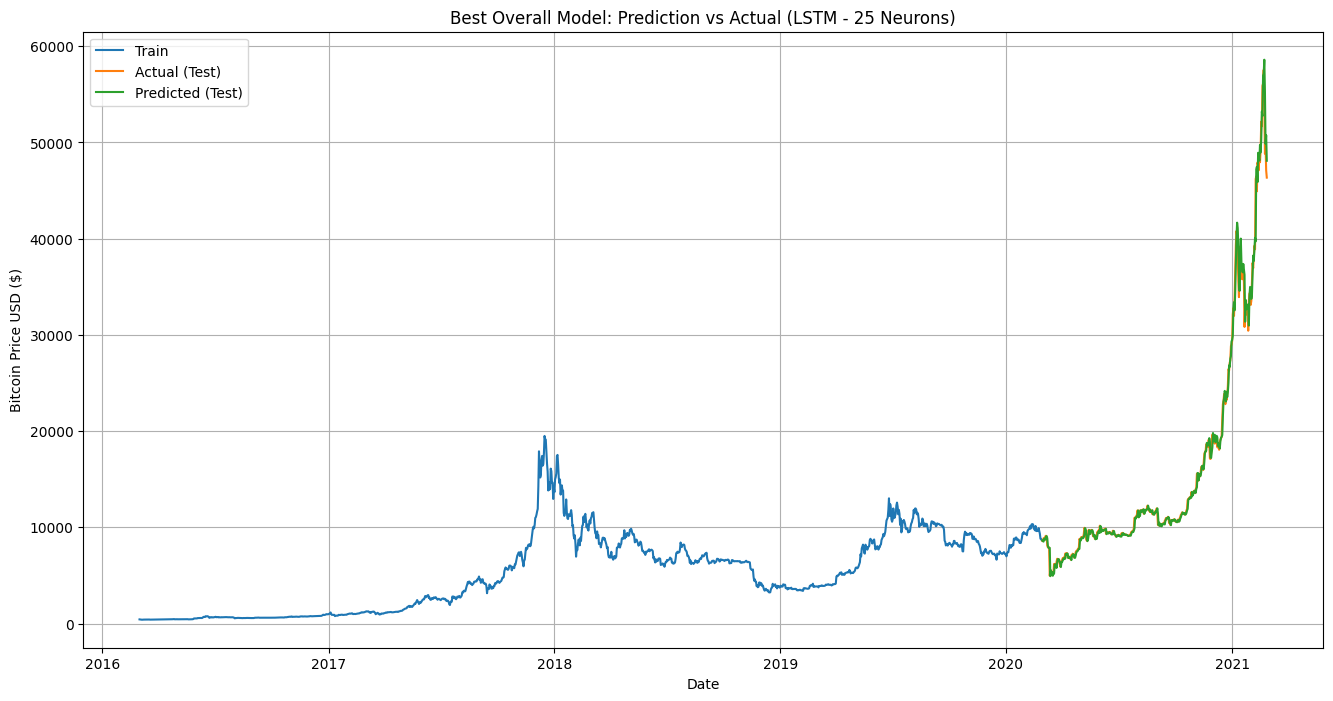

In [ ]:
best_result = results_df.loc[results_df['RMSE'].idxmin()]
best_model_name = best_result['Model']
best_neurons = int(best_result['Neurons'])

print(f"\n--- The best overall model is: {best_model_name} with {best_neurons} neurons ---")
print(f"  Best RMSE: {best_result['RMSE']:.4f}")

print("Re-training the best model for final visualization...")
best_model = build_model(best_model_name, best_neurons, TIME_STEP)

best_model.fit(
    x_train,
    y_train,
    batch_size=72,
    epochs=50,
    verbose=0
)

predictions_scaled = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Create the dataframe for plotting
train_plot = data[:training_data_len]
valid_plot = data[training_data_len:]
valid_plot['Predictions'] = predictions

# Plot
plt.figure(figsize=(16, 8))
plt.title(f'Best Overall Model: Prediction vs Actual ({best_model_name} - {best_neurons} Neurons)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price USD ($)')
plt.plot(train_plot['Close'], label='Train')
plt.plot(valid_plot['Close'], label='Actual (Test)')
plt.plot(valid_plot['Predictions'], label='Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()